## This notebook implements source estimation for emission equation by minimizing relative entropy and L1 norm by means of conic programming 

The detailed deriviations can be found here: ???

The notebook has 3 main parts:
1. Problem definition (functions, forms, geometry etc.)
2. Solving forward emission equation for generating pseudo observations.
3. Solving source estimation problem

In [1]:
import fenics as fem

import mshr
import numpy as np
import math 

import scipy
import scipy.sparse as sp
import scipy.optimize as spo
from scipy.interpolate import RectBivariateSpline

import cvxpy as cp 

import matplotlib.pyplot as plt
import sklearn 
from sklearn.utils import extmath 

from IPython import display
import time
from tqdm import trange, tqdm

import matplotlib.pyplot as plt

#### DOMAIN / FEM setup 

In [2]:
#paralelepiped enclosing the cylinder 
lb_x = 0.0
lb_y = 0.0
lb_z = 0.0
rb_x = 1.3 # cm
rb_y = 1.3 # cm
#height of the solution in the cube 
rb_z = 1.4   # cm

degree = 1    # polynomial degree

In [3]:
PROBLEM = '3D'
# Create mesh
# 2D mesh
if PROBLEM == '2D':
    nsteps = 3
    coordinate_degree = 1
    gdim = 2
    mesh = fem.UnitDiscMesh.create(fem.MPI.comm_world, nsteps, coordinate_degree, gdim)
    fem.plot(mesh)
    #mesh = fem.RectangleMesh(fem.Point(lb_x, lb_y), fem.Point(rb_x, rb_y), Nel_x, Nel_y)
    #elements = 'triangle'

# 3D mesh
if PROBLEM == '3D':
#     geometry = mshr.Cylinder(fem.Point((lb_x+rb_x)/2,(lb_y+rb_y)/2,lb_z), fem.Point((lb_x+rb_x)/2,(lb_y+rb_y)/2,rb_z), radius, radius)
#     mesh = mshr.generate_mesh(geometry, 15)
#     Nel_x = 22
#     Nel_y = 22
#     Nel_z = 24
#     Nel_x = 14
#     Nel_y = 14
#     Nel_z = 16
    Nel_x = 50
    Nel_y = 50
    Nel_z = 56
    
mesh = fem.BoxMesh(fem.Point(lb_x, lb_y, lb_z), fem.Point(rb_x, rb_y, rb_z), Nel_x, Nel_y, Nel_z)
elements = 'tetrahedron'

#### Generating synthetic observations

In [4]:
res = 100
def Trace(func, z):
    xx = np.arange(lb_x,rb_x,(rb_x-lb_x)/res)
    yy = np.arange(lb_y,rb_y,(rb_y-lb_y)/res)
    val2D = np.zeros((xx.shape[0],yy.shape[0]))
    for i in range(xx.shape[0]): 
        for j in range(yy.shape[0]): 
#             if((xx[i]-(lb_x+rb_x)/2)**2+(yy[j]-(lb_y+rb_y)/2)**2 < 0.95*radius**2):
            val2D[i,j] = func(fem.Point(xx[j],yy[i],z))
                    
    return val2D

def plot_trace(func, z):
    trace = Trace(func, z)
    img = plt.imshow(trace)
    return img

In [5]:
# define Sigma to be an integration area where observations are present.
# This is done by defining marker function, i.e., binary labels for grid nodes where observations are given. 
# Note: In a case considered here this is a boundary of a 2D or 3D domain 

# marker function for observed nodes. Defines logical expression for labeling such nodes.
# Note: use <near> instead of == (equality sign) to avoid problem with numerical rounding.
# Note: use on_boundary marker to be sure only boundary nodes would be considered.
# Note: x[0] defines first coordinate of node x, x[1] - the second, x[2] - the third and so on, i.e., (x,y)=(x[0],x[1])
# Note: to define marker you can use logical operations (e.g., &&, ||) and binary operations (>, <, sqrt, near, etc.)
# Note: the present approach will compile marker function string into efficient C++ code, 
# however it is also possible to write Python class to be a marker function (it will be slower but more epressive). 
# More details with examples can be found here: https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html

top_boundary_marker = fem.CompiledSubDomain(f'(near(x[2], {lb_z}) || near(x[2], {rb_z}) || near(x[1], {rb_y}) || near(x[1], {lb_y}) || near(x[0], {rb_x}) || near(x[0], {lb_x}))  && on_boundary')

eps = 1e-10 
num_el = 3
near_boundary_marker = fem.CompiledSubDomain(f'(x[0]<{lb_x + num_el*(rb_x-lb_x)/Nel_x + eps} || x[0]>{rb_x - num_el*(rb_x-lb_x)/Nel_x - eps}) &&'+
                                             f'(x[1]<{lb_y + num_el*(rb_y-lb_y)/Nel_y + eps} || x[1]> {rb_y - num_el*(rb_y-lb_y)/Nel_y - eps}) &&'+
                                             f'(x[2]<{lb_z + num_el*(rb_z-lb_z)/Nel_z + eps} || x[2]> {rb_z - num_el*(rb_z-lb_z)/Nel_z - eps})')

sub_domains = fem.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
sub_domains.set_all(0)
top_boundary_marker.mark(sub_domains, 1)
dSigma = fem.ds(subdomain_id=1, subdomain_data=sub_domains, domain=mesh)


In [6]:
# Define function spaces
P1 = fem.FiniteElement('P', elements, degree)
Q  = fem.FunctionSpace(mesh, P1) 

# mixed_el4 = fem.MixedElement([P1, P1, P1, P1])
# mixed_el5 = fem.MixedElement([P1, P1, P1, P1, P1])

# mixed_el2 = fem.MixedElement([P1, P1])

# V = fem.FunctionSpace(mesh, mixed_el4)
# V5 = fem.FunctionSpace(mesh, mixed_el5)x

# W = fem.FunctionSpace(mesh, mixed_el2)


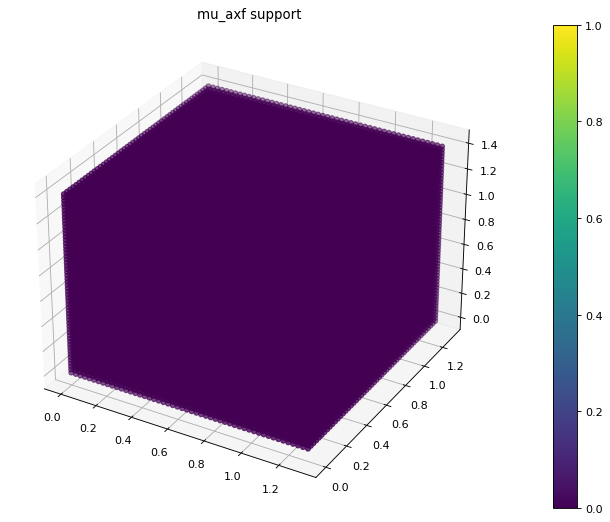

In [16]:
#DEFINE SUPPORT OF mu_axf - a cylinder
phantom_center_x = (rb_x + lb_x)/2.0
phantom_center_y = (rb_y + lb_y)/2.0

phantom_lb_x     = 0.25
phantom_rb_x     = 1.05
phantom_lb_y     = 0.25
phantom_rb_y     = 1.05
phantom_lb_z     = 0.2
phantom_rb_z     = 1.1     # cm
# phantom_radius   = 0.2     # cm

XiPhantom = fem.Function(Q)
dofs = Q.tabulate_dof_coordinates()

def InsideCircle(x,y):
    if (x-phantom_center_x)**2+(y-phantom_center_y)**2 <= phantom_radius**2:
        return 1
    return 0

def InsideCylinder(x,y,z):
    if z < phantom_rb_z and InsideCircle(x,y):
        return 1
    return 0

def InsideCube(x,y,z,lb,rb):
    if rb[0]==rb_x:
        cond_x = (x <= rb[0] and x >= lb[0])
    else:
        cond_x = (x < rb[0] and x >= lb[0])
    
    if rb[1]==rb_y:    
        cond_y = (y <= rb[1] and y >= lb[1])
    else:
        cond_y = (y < rb[1] and y >= lb[1])
    
    if rb[2] == rb_z: 
        cond_z = (z <= rb[2] and z >= lb[2])
    else: 
        cond_z = (z < rb[2] and z >= lb[2])
        
    if cond_x and cond_y and cond_z:
        return 1
    return 0
    
for i in range(dofs.shape[0]):
    if InsideCube(dofs[i,0],dofs[i,1],dofs[i,2],
                  [phantom_lb_x,phantom_lb_y,phantom_lb_z],[phantom_rb_x,phantom_rb_y,phantom_rb_z]): 
#     if InsideCylinder(dofs[i,0],dofs[i,1],dofs[i,2]):
        XiPhantom.vector()[i] = 1
    else:
        XiPhantom.vector()[i] = 0
                
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
img = fem.plot(XiPhantom)
plt.colorbar(img)
tmp = plt.title('mu_axf support')

Text(0.5, 1.0, 'Trace of the phantom')

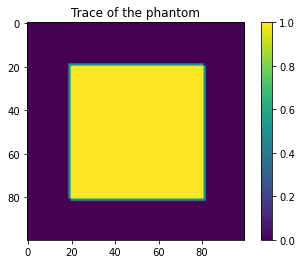

In [20]:
trace = Trace(XiPhantom, 1.0)
img = plt.imshow(trace)
plt.colorbar(img)
plt.title('Trace of the phantom')

#### COEFFICIENTS 

In [107]:
# DEFINE coefficents for EXCITATION EQ
# absorption coefficent of the medium at fluorophore excitation wl
mu_axi = fem.Function(Q)
# absoption of Liposyne at 785nm (ICG excitation), in cm^-1
mu_axi.vector()[:] = 0.023 * np.ones(mu_axi.vector()[:].shape)

# absorption coefficent due to fluorophore at fluorophore excitation wl
mu_axf = fem.Function(Q)
#Original: absoption of ICG at 785nm: depends on concetration, approx. 0.5 per 1 micromolar 
#absoption of ICG at 785nm: depends on concetration, approx. 0.5 cm^-1 per 1 micromolar 
ICG_micromolar = 7
ICG_absoption_coeff = fem.Constant(0.5*ICG_micromolar)
# support of ICG concentration in the domain 
mu_axf.vector()[:] = ICG_absoption_coeff*XiPhantom.vector()[:]

# scattering coefficent of the medium at fluorophore excitation wl
mu_sxp = fem.Function(Q)
# scattering of Liposyne at 785nm 
# in the paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4467592/ they provide a formular to compute it
# 9.84
mu_sxp.vector()[:] = 9.84 * np.ones(mu_sxp.vector()[:].shape)

# diffusion coefficient 
# dx = 1/(3*(mu_axi + mu_axf + mu_sxp))
print('NOTE: dropped mu_axf from Dx')

dx = 1/(3*(mu_axi + mu_sxp))
#absoption coefficient 
kx = mu_axi + mu_axf

#EMISSION EQ
# absorption coefficent of the medium at fluorophore emission wl
mu_ami = fem.Function(Q)
# absoption of Liposyne at 830nm (ICG emission) 
mu_ami.vector()[:] = 0.0289 * np.ones(mu_ami.vector()[:].shape)

# absorption coefficent due to fluorophore at fluorophore emission wl 
mu_amf = fem.Function(Q)
# we assume that there is no quenching (Donal:ICG concentration must be below 10-15 micromolar depending on the medium ICG is enclosed in)
mu_amf.vector()[:] = np.zeros(mu_amf.vector()[:].shape)

# scattering coefficent of the medium at fluorophore emission wl 
mu_smp = fem.Function(Q)
# scattering of Liposyne at 830nm 
# 9.84
mu_smp.vector()[:] = 9.84 * np.ones(mu_smp.vector()[:].shape)

# diffusion coefficient 
dm = 1/(3*(mu_ami + mu_amf + mu_smp))
#absoption coefficient 
km = mu_ami + mu_amf

#gamma for the Robin boundary condition comes from Table 1 of this paper for air / Liposyne interface: 
#https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-10-15-653&id=69564 
g = fem.Constant(2.5156)
#ICG quantum efficiency (check Donal's paper)
Gm = fem.Constant(0.016)

NOTE: dropped mu_axf from Dx


### SOURCE term (synthetic)

In [108]:
class SourceExpression(fem.UserExpression):
    def eval(self, value, x):
        value[0] = 0
#         value[1] = 0
        if PROBLEM == '2D':
            if (abs((lb_x+rb_x)/2.0 - x[0]) < 0.5) & fem.near(x[1], lb_y):
                value[0] = np.sin(np.pi*x[0])

        if PROBLEM == '3D':
            if fem.near(x[2], rb_z):
                value[0] = 1e3*(20+10*np.sin(np.pi*x[0]))
#             value[0] = x[0]**2
    def value_shape(self):
        return ()

trueSource = fem.interpolate(SourceExpression(), Q)   # source

### SOURCE term (from real data)

In [109]:
import os
import scipy.io

source data norm:  3441.956856208398


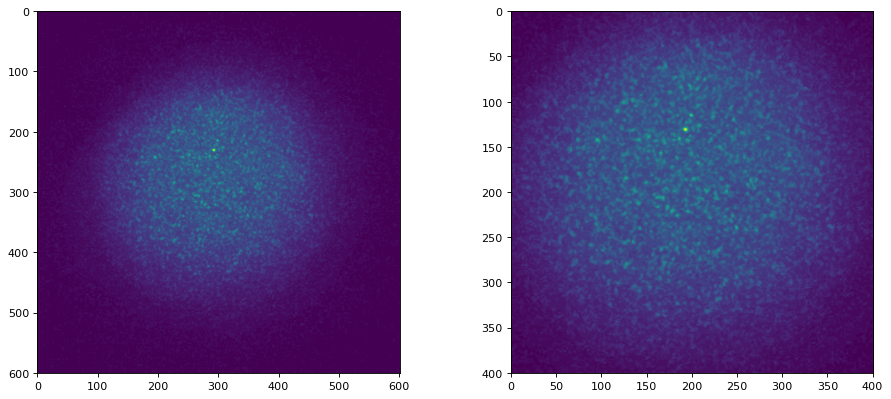

In [185]:
folder=os.path.expanduser('~')+'/Library/CloudStorage/Box-Box/UCD_laser_source_videos/All_Phantom_Data/ASCIIs/source data'
path = folder + '/RGBsource'

source_data = np.loadtxt(path)
# source_data = source_data / source_data.max()

print('source data norm: ', np.linalg.norm(source_data))
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.imshow(source_data)

# we need to crop the image to the rectangular cuvette
source_data = source_data[100:-100, 100:-100]
plt.subplot(1,2,2)
plt.imshow(source_data)

In [186]:
import scipy.signal as sps
source_data_filt = sps.medfilt(source_data, kernel_size=15)
source_data_filt_norm = source_data_filt / source_data_filt.max()

In [187]:
# convert source data to the Fenics functin
trueSource = fem.Function(Q)
dofs = Q.tabulate_dof_coordinates()
    
for i in range(dofs.shape[0]):
#     dofs[i,0],dofs[i,1],dofs[i,2]
        
    if fem.near(dofs[i,2], rb_z):
        p_x = round((dofs[i,0] / rb_x) * (source_data.shape[1]-1))
        p_y = round((dofs[i,1] / rb_y) * (source_data.shape[0]-1))

        trueSource.vector()[i] = source_data_filt_norm[p_y, p_x]

Text(0.5, 1.0, 'Trace of the phantom')

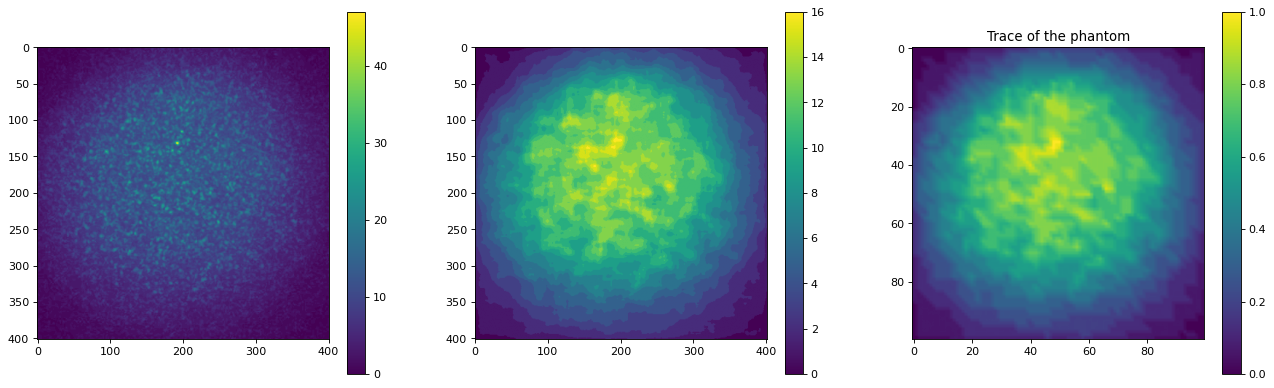

In [188]:
# plot the true source
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1,3,1)
img = plt.imshow(source_data)
plt.colorbar(img)

plt.subplot(1,3,2)
img = plt.imshow(source_data_filt)
plt.colorbar(img)

plt.subplot(1,3,3)
trace = Trace(trueSource, 1.4)
img = plt.imshow(trace)
plt.colorbar(img)
plt.title('Trace of the phantom')

### Solving the equations

In [189]:
# bilinear forms
def ax_form(u,v):
    return dx*fem.dot(fem.grad(u), fem.grad(v))*fem.dx + kx*u*v*fem.dx + 0.5*g*u*v*fem.ds

def ax_nomuaxf_form(u,v):
    return dx*fem.dot(fem.grad(u), fem.grad(v))*fem.dx + mu_axi*u*v*fem.dx + 0.5*g*u*v*fem.ds

def am_form(u,v):
    return dm*fem.dot(fem.grad(u), fem.grad(v))*fem.dx + km*u*v*fem.dx + 0.5*g*u*v*fem.ds


In [190]:
# Exitation equation
ux = fem.TrialFunction(Q)
vx = fem.TestFunction(Q)

ax_muax  = ax_form(ux, vx)
rhs = trueSource/2*vx*fem.ds

hatphi = fem.Function(Q)
fem.solve(ax_muax==rhs, hatphi, solver_parameters={'linear_solver':'mumps'})

# if np.min(hatphi.vector()[:])<0:
#     print('WARNING: FEM solution Phi_ex has negative components! Setting negatives to 0!')
#     tmp_ind = hatphi.vector()[:]
#     tmp_ind[tmp_ind<0] = 0
#     hatphi.vector()[:] = tmp_ind 
    
print('hatPhi >= 0:  ', np.all(hatphi.vector()[:]>=0), 'Sum hat_Phi = ', np.sum(hatphi.vector()[:]<0), 'Min hat_Phi = ', np.min(hatphi.vector()[:]))

hatPhi >= 0:   True Sum hat_Phi =  0 Min hat_Phi =  4.3260433407668776e-09


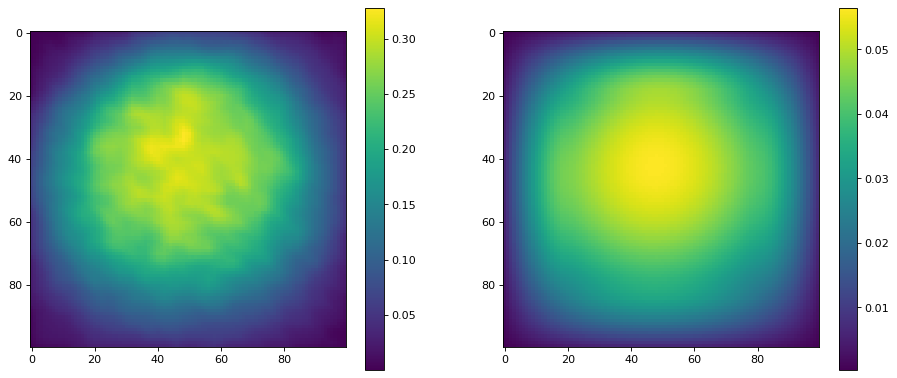

In [191]:
# plot the exitation solution
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
img = plot_trace(hatphi, 1.4)
plt.colorbar(img)

plt.subplot(1,2,2)
img = plot_trace(hatphi, 1.1)
plt.colorbar(img)

In [192]:
# emission equation
ux = fem.TrialFunction(Q)
vx = fem.TestFunction(Q)

Sf = fem.Function(Q)
Sf.vector()[:] = np.multiply(mu_axf.vector()[:],hatphi.vector()[:])

rhsSf = Sf*vx*fem.dx
am0   = ax_form(ux, vx)

phiSf = fem.Function(Q)
fem.solve(am0==rhsSf, phiSf, solver_parameters={'linear_solver':'mumps'})

In [193]:
phiSf.vector()[:].max()

0.022120630573566787

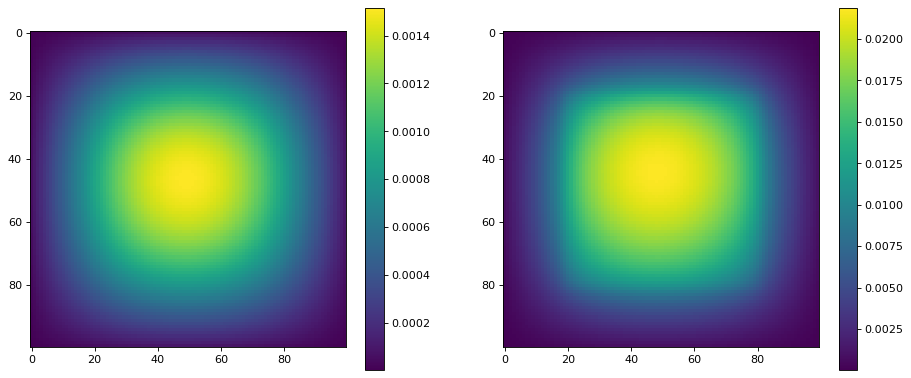

In [194]:
# plot the emission solution
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
img = plot_trace(phiSf, 1.4)
plt.colorbar(img)

plt.subplot(1,2,2)
img = plot_trace(phiSf, 1.1)
plt.colorbar(img)

#### Comparing against actual observations

In [195]:
import endeform.reflections.glare_detection as glare
from scipy import interpolate

source data norm:  3413.89674712051


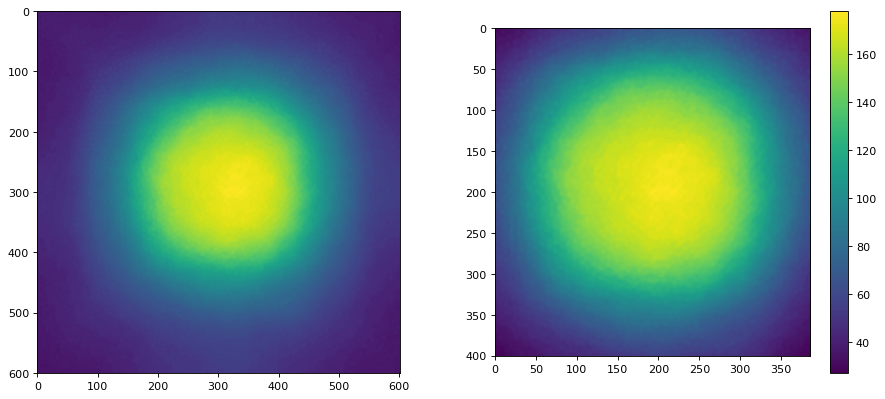

In [196]:
folder=os.path.expanduser('~')+'/Library/CloudStorage/Box-Box/UCD_laser_source_videos/All_Phantom_Data/ASCIIs'
# path = folder + '/medFilt_RGB3mmTop7uM'
path = folder + '/medFilt_RED3mmTop7uM'

obs_data = np.loadtxt(path)

print('source data norm: ', np.linalg.norm(source_data))
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.imshow(obs_data)

# we need to crop the image to the rectangular cuvette
obs_data = obs_data[100:-100, 120:-95]
plt.subplot(1,2,2)
plt.imshow(obs_data)
plt.colorbar()

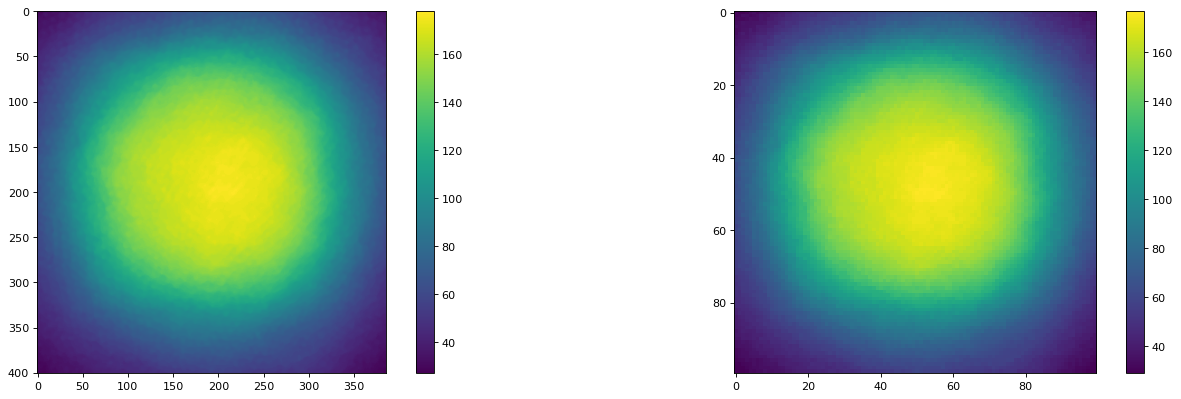

In [197]:
x = np.arange(0, res+0.0001, res/(obs_data.shape[1]-1))
y = np.arange(0, res+0.0001, res/(obs_data.shape[0]-1))
xx, yy = np.meshgrid(x, y)
# x = xx[~glare_mask]
# y = yy[~glare_mask]

x_new = np.arange(0, res)
y_new = np.arange(0, res)

# newarr = obs_data.copy()
# newarr = newarr[~glare_mask]

# xx_new, yy_new = np.meshgrid(x_new, y_new)
# obs_data_interp = interpolate.griddata((x[:], y[:]), newarr.ravel(), (xx_new,yy_new), method='cubic')


import scipy.interpolate as spi
# , kind='cubic'
f = spi.interp2d(x, y, obs_data)
obs_data_interp = f(x_new, y_new)

plt.figure(num=None, figsize=(21, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.imshow(obs_data)
plt.colorbar()

# # we need to crop the image to the rectangular cuvette
# plt.subplot(1,3,2)
# plt.imshow(glare_mask)

# we need to crop the image to the rectangular cuvette
plt.subplot(1,2,2)
plt.imshow(obs_data_interp)
plt.colorbar()

relative L2 difference =  0.3190830647286872


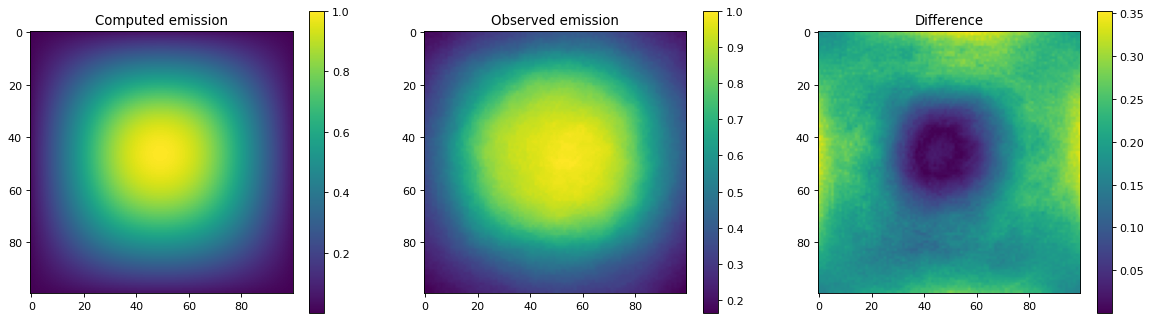

In [199]:
# plot the true source
plt.figure(num=None, figsize=(18, 5), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,3,1)
# img = plt.imshow(obs_data)
# plt.colorbar(img)

plt.subplot(1,3,1)
phi_em_top = Trace(phiSf, rb_z)
phi_em_top = phi_em_top / phi_em_top.max()
img = plt.imshow(phi_em_top)
plt.colorbar(img)
plt.title('Computed emission')

plt.subplot(1,3,2)
obs_data_interp_norm = obs_data_interp / obs_data_interp.max()
# obs_data_interp = obs_data_interp / obs_data_interp.max()
img = plt.imshow(obs_data_interp_norm)
plt.colorbar(img)
plt.title('Observed emission')

plt.subplot(1,3,3)
obs_diff = np.abs(phi_em_top-obs_data_interp_norm)
img = plt.imshow(np.abs(obs_diff))
plt.colorbar(img)
plt.title('Difference')

print('relative L2 difference = ', np.linalg.norm(obs_diff)/np.linalg.norm(obs_data_interp_norm))

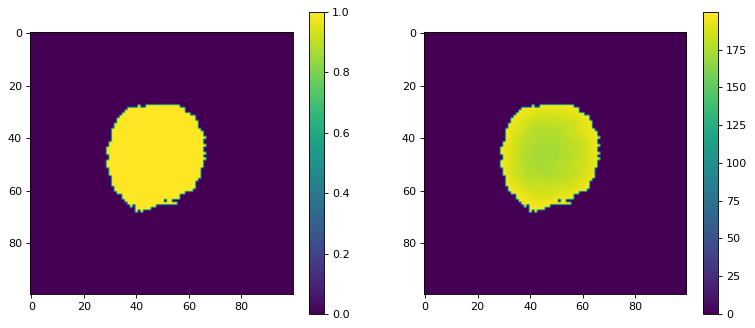

In [200]:
plt.figure(num=None, figsize=(18, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
mask = (diff<0.1).astype(int)
img = plt.imshow(mask)
plt.colorbar(img)

plt.subplot(1,3,2)
prod = obs_data_interp/phi_em_top*mask
img = plt.imshow(prod)
plt.colorbar(img)


In [201]:
multiplier = (obs_data_interp/phi_em_top*mask).max()
multiplier

199.9917800769834

In [202]:
Trace(phi_em_norm, rb_z).max()

0.06856396831125827

#### UNIT tests

In [11]:
#UNIT test 1: is source reconstructing the solution well? 

ux = fem.TrialFunction(Q)
vx = fem.TestFunction(Q)

ax_muax  = ax_form(ux, vx) 
rhs = trueSource/2*vx*fem.ds 

hatphi = fem.Function(Q)
phibar = fem.Function(Q)
Sf     = fem.Function(Q)
phiSf = fem.Function(Q)

fem.solve(ax_muax==rhs, hatphi, solver_parameters={'linear_solver':'mumps'})
if np.min(hatphi.vector()[:])<0:
    print('WARNING: FEM solution Phi_ex has negative components! Setting negatives to 0!')
    tmp_ind = hatphi.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    hatphi.vector()[:] = tmp_ind 
    
print('hatPhi >= 0:  ', np.all(hatphi.vector()[:]>=0), np.sum(hatphi.vector()[:]<0), 'Min Phi_x = ', np.min(hatphi.vector()[:]))


# Sf = mu_axf*hatphi
Sf.vector()[:] = np.multiply(mu_axf.vector()[:],hatphi.vector()[:])

ax0  = ax_nomuaxf_form(ux, vx) 
rhsSf = trueSource/2*vx*fem.ds - Sf*vx*fem.dx
print('WARNING: FEM interpolation error - if Sf in rhsSf is substituted by mu_axf*hatphi then Phi_Sf = Phi_ex!')
fem.solve(ax0 ==rhsSf, phiSf, solver_parameters={'linear_solver':'mumps'})
if np.min(phiSf.vector()[:])<0:
    print('WARNING: FEM solution Phi_Sf has negative components! Setting negatives to 0!')
    tmp_ind = phiSf.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    phiSf.vector()[:] = tmp_ind 

print('State space dimension = ', phiSf.vector()[:].size)
print('FEM INterpolation error: \nRel. Rn-err: |Phi_ex - Phi_Sf|  = ', np.sqrt(np.linalg.norm(phiSf.vector()[:] - hatphi.vector()[:])/np.linalg.norm(hatphi.vector()[:])))
print('Rel. L2-err: |Phi_ex - Phi_Sf|  = ', np.sqrt(fem.assemble((hatphi-phiSf)**2*fem.dx))/np.sqrt(fem.assemble(hatphi**2*fem.dx)))
print('Phi_Sf >= 0:  ', np.all(phiSf.vector()[:]>=0), '\nMin Phi_Sf = ', np.min(phiSf.vector()[:]), 'Min Phi_ex = ', np.min(hatphi.vector()[:]))

fem.solve(ax_nomuaxf_form(ux, vx) == trueSource/2*vx*fem.ds, phibar, solver_parameters={'linear_solver':'mumps'})
if np.min(phibar.vector()[:])<0:
    print('WARNING: FEM solution Phi_Sf has negative components! Setting negatives to 0!')
    tmp_ind = phibar.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    phibar.vector()[:] = tmp_ind 

print('Phi_bar >= 0: ', np.all(phibar.vector()[:]>=0),'Min Phi_bar = ', np.min(phibar.vector()[:]))



Calling FFC just-in-time (JIT) compiler, this may take some time.
hatPhi >= 0:   True 0 Min Phi_x =  0.0175578930927336
Calling FFC just-in-time (JIT) compiler, this may take some time.
State space dimension =  3825
FEM INterpolation error: 
Rel. Rn-err: |Phi_ex - Phi_Sf|  =  0.01305694070299575
Rel. L2-err: |Phi_ex - Phi_Sf|  =  0.00019540765508085982
Phi_Sf >= 0:   True 
Min Phi_Sf =  0.01753222844558452 Min Phi_ex =  0.0175578930927336
Phi_bar >= 0:  True Min Phi_bar =  0.0193104857042094


#### RESCALING 

In [ ]:
scale             = hatphi.vector()[:].sum() #fem.assemble(hatphi*fem.dx) 
SrcBndr_scaled    = trueSource/2/scale*vx*fem.ds 
hatphi_scaled     = fem.Function(Q)
fenics_solver = 'bicgstab'

fem.solve(ax_muax == SrcBndr_scaled, hatphi_scaled, solver_parameters={'linear_solver':fenics_solver,'preconditioner': 'ilu'})
if np.min(hatphi_scaled.vector()[:])<0:
    print('WARNING: FEM solution Phi_ex has negative components! Setting negatives to 0!')
    tmp_ind = hatphi_scaled.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    hatphi_scaled.vector()[:] = tmp_ind 
    
Sf_scaled     = fem.Function(Q)
Sf_scaled.vector()[:] = np.multiply(mu_axf.vector()[:], hatphi_scaled.vector()[:])

phiSf_scaled = fem.Function(Q)
fem.solve(ax0 ==SrcBndr_scaled - Sf_scaled*vx*fem.dx, phiSf_scaled, solver_parameters={'linear_solver':fenics_solver,'preconditioner': 'ilu'})

if np.min(phiSf_scaled.vector()[:])<0:
    print('WARNING: FEM solution Phi_Sf has negative components! Setting negatives to 0!')
    tmp_ind = phiSf_scaled.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    phiSf_scaled.vector()[:] = tmp_ind 



print(scale, fem.assemble(hatphi_scaled*fem.dx), (hatphi_scaled.vector()[:]).sum(), fem.assemble(Sf_scaled*fem.dx), (Sf_scaled.vector()[:]).sum()/float(ICG_absoption_coeff), phiSf_scaled.vector()[:].sum()) 

print('Rel. Rn-err: |Phi_ex - Phi_Sf|  = ', np.sqrt(np.linalg.norm(phiSf_scaled.vector()[:] - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:])))
print('Rel. L2-err: |Phi_ex - Phi_Sf|  = ', np.sqrt(fem.assemble((hatphi_scaled-phiSf_scaled)**2*fem.dx))/np.sqrt(fem.assemble(hatphi_scaled**2*fem.dx)))

phibar_scaled = fem.Function(Q)
fem.solve(ax_nomuaxf_form(ux, vx) == SrcBndr_scaled, phibar_scaled, solver_parameters={'linear_solver':'mumps'})
if np.min(phibar_scaled.vector()[:])<0:
    print('WARNING: FEM solution Phi_Sf has negative components! Setting negatives to 0!')
    tmp_ind = phibar_scaled.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    phibar_scaled.vector()[:] = tmp_ind 



print('Phi_bar >= 0: ', np.all(phibar_scaled.vector()[:]>=0), '\nMin Phi_bar = ', np.min(phibar_scaled.vector()[:]), 'Min Phi_ex = ', np.min(hatphi_scaled.vector()[:]))

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Sf_scaled.vector()[:]/float(ICG_absoption_coeff))
plt.plot(hatphi_scaled.vector()[:])

# plt.plot(mu_axf.vector()[:]/float(ICG_absoption_coeff))

In [ ]:
#Relative ENTROPY tests 
tmp_denom = phiSf_scaled.vector()[:]*mu_axf.vector()[:]/float(ICG_absoption_coeff)
tmp_nom = Sf_scaled.vector()[:]
print('Sum (Sf Log ( Sf / Phi_Sf)) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff), phiSf_scaled.vector()[:]).sum(), '\nSum Sf Log (Sum Sf / Sum_{Sf>0} Phi_Sf) = ', scipy.special.rel_entr(tmp_nom.sum()/float(ICG_absoption_coeff),tmp_denom.sum()), '\nSum Sf Log (Sum Sf) = ',Sf_scaled.vector()[:].sum()/float(ICG_absoption_coeff)*np.log(Sf_scaled.vector()[:].sum()/float(ICG_absoption_coeff)))
#check ratio sf / sol
tmp = Sf_scaled.vector()[:]/float(ICG_absoption_coeff)/phiSf_scaled.vector()[:]
print('max (Sf / Phi_Sf) =', np.max(tmp[tmp>0]), 'min (Sf_nnz / phiSf) = ', np.min(tmp[tmp>0]))#,tmp_nom.sum()+0.1,tmp_denom.sum(), scipy.special.rel_entr(tmp_nom.sum()+0.0004,tmp_denom.sum()),tmp_nom.sum()*np.log(tmp_nom.sum()/tmp_denom.sum()))

In [ ]:
#GENERATE SYNTHETIC OBSERVATIONS
M = fem.assemble(ux*vx*fem.dx).array()
print(' Mass matrix >= 0 ', np.all(M>=0)) 

S_excite = fem.assemble(ax_nomuaxf_form(ux, vx)).array()
# A_excite = np.linalg.solve(S_excite,M)

S_emit = fem.assemble(am_form(ux, vx)).array()
dofs = Q.tabulate_dof_coordinates()
is_dof_on_boundary = np.array([top_boundary_marker.inside(point, True) for point in dofs])

is_dof_near_boundary = np.array([near_boundary_marker.inside(point, True) for point in dofs])
is_dof_inner = np.array([not near_boundary_marker.inside(point, True) for point in dofs])

# is_TV_bdr_layer = np.array([TV_bdr_layer_marker.inside(point, True) for point in dofs])
# not_TV_bdr_layer = np.array([not TV_bdr_layer_marker.inside(point, True) for point in dofs])

# is_dof_on_boundary = np.array([top_boundary_marker.inside(point, True) for point in dofs])

Tr       = np.eye(dofs.shape[0])[is_dof_on_boundary, :]
Tr_near  = np.eye(dofs.shape[0])[is_dof_near_boundary, :]
Tr_inner = np.eye(dofs.shape[0])[:,is_dof_inner]

print('Inner cube points = ', Tr_inner.shape)
if np.abs(Tr_near@Sf_scaled.vector()[:]).sum()==0 and np.abs(Sf_scaled.vector()[:] - Tr_inner@Sf_scaled.vector()[is_dof_inner]).sum()==0: 
    print('True Sf is in the inner cube.')
else:
    print(np.abs(Tr_near@Sf_scaled.vector()[:]).sum(), np.abs(Sf_scaled.vector()[:] - Tr_inner@Sf_scaled.vector()[is_dof_inner]).sum())
        

A_bdr = Tr@np.linalg.solve(S_emit,float(Gm)*M)

y_tr_scaled = A_bdr@Sf_scaled.vector()[:]

tmp = Sf_scaled.vector()[is_dof_inner]
print(np.linalg.norm(y_tr_scaled - A_bdr@Tr_inner@tmp), np.linalg.norm(y_tr_scaled - A_bdr@Sf_scaled.vector()[:]))

In [ ]:
#UNIT TEST2 find phi_x corresponding to the source term of the form Sf = mu_axf phi_x: phi_x = Sˆ-1 M Sf, (note that Sf as defined above cannot be used as it is missing Mass matrix M in its definition)

src_bndr_scaled = fem.assemble(SrcBndr_scaled)
print('Src boundary >= 0', np.all(src_bndr_scaled>=0))
# Tr = np.eye(S.shape[0])
print('Rel. Rn-err |S_ex phibar        - S_bndr| = ', np.sqrt(np.linalg.norm(S_excite@phibar_scaled.vector()[:]- src_bndr_scaled)/np.linalg.norm(src_bndr_scaled)))
print('Rel. Rn-err |S_ex hatphi + M Sf - S_bndr| = ', np.sqrt(np.linalg.norm(S_excite@hatphi_scaled.vector()[:] + M@Sf_scaled.vector()[:] - src_bndr_scaled)/np.linalg.norm(src_bndr_scaled)))

hatphi_Sf = np.linalg.solve(S_excite, src_bndr_scaled-M@Sf_scaled.vector()[:])
print('hatphi_Sf >= 0', np.all(hatphi_Sf>=0), '\nFEM INterpolation error: \nRel. Rn-err |hatphi_Sf - hatphi| = ', np.sqrt(np.linalg.norm(hatphi_Sf - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:])))
np.linalg.norm(M@np.diag(hatphi_scaled.vector()[:])@mu_axf.vector()[:]/float(ICG_absoption_coeff) - M@Sf_scaled.vector()[:]/float(ICG_absoption_coeff) )

#### mu_axf estimation

In [ ]:
plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(phibar_scaled.vector()[:])
plt.plot(hatphi_scaled.vector()[:])
np.linalg.norm(phibar_scaled.vector()[:]-hatphi_scaled.vector()[:])/np.linalg.norm(phibar_scaled.vector()[:])

In [ ]:
# Phi_ex, true light distribution in the cube due to the normalised source
# The source is normalized so that Phi_ex is a probability distribution: sum Phi_ex = 1, Phi_ex >= 0 
# phibar_scaled - light distribution in the domain with no absoption due to the same normalized source


min_portion_of_Phiex_in_muaxf =  0.001 # lower bound on how much of distribution's mass is contained in the support of mu_axf
rel_absoption_strength        = 0.7 # maximal number c>0 such that Phi_ex >= c Phi_bar 

A_bdr_scaled = A_bdr#/np.transpose(np.matlib.repmat(y_tr_scaled,A_bdr.shape[1],1))
y_tr_sign = y_tr_scaled#np.sign(y_tr_scaled)

nS = Tr_inner.shape[1]

nD = len(phibar.vector()[:])
# nS = nD 

Svar = cp.Variable(shape=nS, nonneg=True)
Dvar = cp.Variable(shape=nD, nonneg=True)

constraints = [Dvar>=phibar_scaled.vector()[:]*rel_absoption_strength, Svar<=Dvar[is_dof_inner], 
               Dvar<= phibar_scaled.vector()[:], 
               S_excite@Dvar + M@Tr_inner@Svar == src_bndr_scaled, 
#                A_bdr_scaled@Tr_inner@Svar == y_tr_sign, 
               cp.sum(Dvar)==1, cp.sum(Svar)>=min_portion_of_Phiex_in_muaxf*float(ICG_absoption_coeff), cp.sum(Svar) <= float(ICG_absoption_coeff)*1.5*min_portion_of_Phiex_in_muaxf]

obj  = cp.Minimize(cp.sum(cp.rel_entr(Svar/float(ICG_absoption_coeff), Dvar[is_dof_inner])) +  np.abs(np.log(min_portion_of_Phiex_in_muaxf))/float(ICG_absoption_coeff)*cp.sum(Svar) + 1/2*cp.sum(cp.square(A_bdr_scaled@Tr_inner@Svar - y_tr_sign)))

prob = cp.Problem(obj, constraints)

solver = cp.SCS
solver = cp.ECOS
# solver = cp.GUROBI
if solver == cp.SCS: 
    prob.solve(solver,verbose = True, max_iters=150000,eps_abs=1e-6,eps_rel=1e-6)
elif solver == cp.ECOS: 
    prob.solve(solver,verbose = True, max_iters=1000) 
        


In [ ]:
Sf_est = Tr_inner@Svar.value
print('#(Sf_est>Dvar) = ', len(Sf_est[Sf_est > Dvar.value]), 'Min phibar = ',np.min(phibar_scaled.vector()[:])*0.7, 'Min. Dvar = ', np.min(Dvar.value), 'Min Svar = ', np.min(Svar.value))
# Sf_est = Svar.value
# Sf_est[Svar.value<=1e-6]=0
print('Rel. emission eq. error = ', np.linalg.norm(A_bdr@Sf_est - y_tr_scaled)/np.linalg.norm(y_tr_scaled))
# print('Rel. emission eq. error = ', np.linalg.norm(S_emit@PhiEmvar.value - float(Gm)*M@Sf_est)/np.linalg.norm(float(Gm)*M@Sf_est))

print('Rel. excitation eq. error =', np.linalg.norm(S_excite@Dvar.value + M@Sf_est - src_bndr_scaled)/np.linalg.norm( src_bndr_scaled))
# print('Rel. |hatphi - Dvar|/|hatphi| =', np.linalg.norm(Dvar.value - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:]))
# print('NNz =', len(Sf_est) - (Sf_est<=1e-3).sum(), 'Dim = ', len(Sf_est))

# tmp_ratio = Sf_est/Dvar.value
# print('Ratios (min, av, max)', np.min(tmp_ratio), np.abs(np.mean(tmp_ratio)),np.max(tmp_ratio))
# plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(np.abs(tmp_ratio))
# plt.plot(np.mean(tmp_ratio)*np.ones_like(tmp_ratio))

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Dvar.value)
plt.plot(hatphi_scaled.vector()[:])
# plt.colorbar(img)
msg = np.array(("|hatphi - Dvar|_2/|hatphi|_2 = "))
err_str = np.format_float_positional(np.linalg.norm(Dvar.value - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:]))
plt.title(np.char.add(msg,err_str))

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,2)
img = fem.plot(hatphi_scaled)
plt.colorbar(img)
plt.title('True phi_x')

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
sol1 = fem.Function(Q)
sol1.vector()[:] = Dvar.value
img1 = fem.plot(sol1)
plt.colorbar(img1)
plt.title('Estimated phi_x')

print('KL(Sf_est, Dvar) = ', scipy.special.rel_entr(Sf_est/float(ICG_absoption_coeff), Dvar.value).sum(),'\nRel. entropy (log-sum) = ', scipy.special.rel_entr(Sf_est.sum()/float(ICG_absoption_coeff), Dvar.value.sum()))#, np.log(np.abs(np.mean(Sf_est/Dvar.value)))*Sf_est.sum())
print('KL(Sf_true, phi_bar - S_x\M Sf_true) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(),scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),hatphi_scaled.vector()[:]).sum())
print('KL(Sf_true, Dvar) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),Dvar.value).sum())
print('|Sf_true|_1 = ', np.abs(Sf_scaled.vector()[:]).sum(), '\n|Sf_est|_1 = ', np.abs(Sf_est).sum(), '\n|Tr Sf|_1 = ',np.abs(Tr_near@Sf_scaled.vector()[:]).sum(), '\n|Tr Sf_est|_1 = ',np.abs(Tr_near@Sf_est).sum())
print('Cost(Sf_true) = ', np.abs(np.log(low_bound))/float(ICG_absoption_coeff)*np.abs(Sf_scaled.vector()[:]).sum() + scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(), '\nCost(Sf_est,Dvar) = ', np.abs(np.log(low_bound))*np.abs(Sf_est).sum()/float(ICG_absoption_coeff)+scipy.special.rel_entr(Sf_est/float(ICG_absoption_coeff), Dvar.value).sum())
print(Dvar.value.sum(),Sf_est.sum()/float(ICG_absoption_coeff))

In [ ]:
# UNIT TEST:  TV regularization
A_bdr_scaled = A_bdr 
mF = A_bdr_scaled@np.diag(Dvar.value*float(ICG_absoption_coeff))
data_misfit_normalization = 1/np.linalg.norm(y_tr_sign,2)**2
y_tr_sign = y_tr_scaled

Svar1 = cp.Variable(shape=nD, nonneg=True)
Dvar1 = Dvar.value

tikh = 1e-5
TVreg = cp.tv(Svar1[TV_cubes_index[0,:]])
for jj in range(1,TV_cubes_index.shape[0]): 
    TVreg = TVreg + cp.tv(Svar1[TV_cubes_index[jj,:]])
    
Cost  = data_misfit_normalization*cp.sum_squares(mF@Svar1 - y_tr_sign) + tikh*TVreg

cp.Problem(cp.Minimize(Cost),[cp.sum(Svar1)>=100, Svar1<=1]).solve(verbose=True, eps_abs=2e-10, eps_rel=2e-10, max_iter=150000)
# cp.Problem(cp.Minimize(cp.tv(Svar1)),[mF@Svar1 == y_tr_sign]).solve(verbose=True, solver=cp.SCS)

In [ ]:
gk    = cp.Parameter(nD)
gk.value = mu_axf.vector()[:]/float(ICG_absoption_coeff)
TVregk = cp.tv(gk[TV_cubes_index[0,:]])
for jj in range(1,TV_cubes_index.shape[0]): 
    TVregk = TVregk + cp.tv(gk[TV_cubes_index[jj,:]])
    
dmsft = data_misfit_normalization*cp.sum_squares(mF@Svar1 - y_tr_scaled).value
dmsft_true = data_misfit_normalization*cp.sum_squares(mF@gk - y_tr_scaled).value 
print('Data misfit = ', dmsft, 'TV=' , TVreg.value)
print('True misfit = ', dmsft_true,'TV= ', TVregk.value)
print('Cost = ', Cost.value, 'True cost = ', dmsft_true + tikh*TVregk.value)
print('Constraint = ', cp.sum(Svar1).value, 'True constraint = ',cp.sum(gk).value)
# print('Cnst.misfit = ', data_misfit_normalization*cp.sum_squares(mF@np.ones_like(Svar1.value)*0.041 - y_tr_scaled).value)

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(Svar1.value,label='Est') 
plt.plot(gk.value,label='True')
msg = np.array(("Rel. Rn-error = "))
sol1 = fem.Function(Q)
sol1.vector()[:] = Svar1.value
err_str = np.format_float_positional(np.sqrt(fem.assemble((mu_axf/float(ICG_absoption_coeff)-sol1)**2*fem.dx)/fem.assemble((mu_axf/float(ICG_absoption_coeff))**2*fem.dx)))
plt.title(np.char.add(msg,err_str))
plt.legend()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
img1 = fem.plot(sol1)
plt.colorbar(img1)

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
sol1.vector()[:] = gk.value
img1 = fem.plot(sol1)
plt.colorbar(img1)


## SANDBOX

In [ ]:
# UNIT TEST:  Solve with method of multipliers.
A_bdr_scaled = A_bdr 
mF = A_bdr_scaled@np.diag(Dvar.value*float(ICG_absoption_coeff))

y_tr_sign = y_tr_scaled

Svar1 = cp.Variable(shape=nD, nonneg=True)

tikh = 1
# PhiEmvar = cp.Variable(shape=nD, nonneg=True)

Dvar1 = Dvar.value

#                 A_bdr_scaled@dD@Svar1             == y_tr_sign, 
#                 S_emit@PhiEmvar == float(Gm)*M@dD@Svar1,  Tr@PhiEmvar == y_tr_sign]
               #                A_bdr = Tr@np.linalg.solve(S_emit,float(Gm)*M), y_tr_scaled = A_bdr@Sf_scaled.vector()[:]
#                S_emit@PhiEmvar == float(Gm)*M@Tr_inner@Svar,  PhiEmvar>=0, Tr@PhiEmvar == y_tr_sign, ]
#                 S_excite@Dvar.value   +  M@dD@Svar1 == src_bndr_scaled, 
#                 cp.sum(Svar1)<= nD/2 ]#, cp.sum(Svar1) <= float(ICG_absoption_coeff)*1.5*low_bound]

resid = mF@Svar1 - y_tr_sign
lgr_mult = cp.Parameter(len(y_tr_sign))
lgr_mult.value = np.zeros(len(y_tr_sign))
aug_lagr = cp.tv(Svar1) + lgr_mult.T@resid + (tikh/2)*cp.sum_squares(resid)
for t in trange(10):
    cp.Problem(cp.Minimize(aug_lagr), [Svar1<=1, cp.sum(Svar1)>=100]).solve()
    lgr_mult.value += tikh*resid.value
    print("Res value from method of multipliers: {}".format(np.linalg.norm(resid.value)))

In [ ]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
print(np.linalg.norm(mF@mu_axf.vector()[:]/float(ICG_absoption_coeff) - y_tr_scaled),mu_axf.vector()[:].sum(),Svar1.value.sum())
print(np.linalg.norm(mF@Svar1.value - y_tr_scaled)/np.linalg.norm(y_tr_scaled),mu_axf.vector()[:].sum(),Svar1.value.sum()) #Svar1.value - Svar1.value))
plt.plot(Svar1.value)

gk    = cp.Parameter(nD)
gk.value = mu_axf.vector()[:]/float(ICG_absoption_coeff)
print(cp.tv(Svar1).value, cp.tv(gk).value)

In [ ]:
# UNIT TEST: diag trick + L1 minimization 

A_bdr_scaled = A_bdr 
mF = A_bdr_scaled@dD
dD = np.diag(Dvar.value*float(ICG_absoption_coeff))
y_tr_sign = y_tr_scaled#np.sign(y_tr_scaled)

# Svar1 = cp.Variable(shape=nS, nonneg=True)
Svar1 = cp.Variable(shape=nD, nonneg=True)
gk    = cp.Parameter(len(y_tr_sign))  
gk.value = 0*y_tr_sign
tikh = 40 
# PhiEmvar = cp.Variable(shape=nD, nonneg=True)

Dvar1 = Dvar.value


constraints1 = [Svar1<=1]
#                 A_bdr_scaled@dD@Svar1             == y_tr_sign, 
#                 S_emit@PhiEmvar == float(Gm)*M@dD@Svar1,  Tr@PhiEmvar == y_tr_sign]
               #                A_bdr = Tr@np.linalg.solve(S_emit,float(Gm)*M), y_tr_scaled = A_bdr@Sf_scaled.vector()[:]
#                S_emit@PhiEmvar == float(Gm)*M@Tr_inner@Svar,  PhiEmvar>=0, Tr@PhiEmvar == y_tr_sign, ]
#                 S_excite@Dvar.value   +  M@dD@Svar1 == src_bndr_scaled, 
#                 cp.sum(Svar1)<= nD/2 ]#, cp.sum(Svar1) <= float(ICG_absoption_coeff)*1.5*low_bound]

obj1  = cp.Minimize(cp.sum(cp.abs(Svar1)) + tikh/2*cp.sum_squares(mF@Svar1-gk)) 
prob1 = cp.Problem(obj1, constraints1)
prob1.solve(verbose=True)
gk.value = y_tr_sign - mF@Svar1.value 

for jj in trange(250): 
    prob1.solve(warm_start=True,verbose=True)
    gk_prev = gk.value
    gk.value = gk_prev + y_tr_sign - mF@Svar1.value
    print(np.linalg.norm(mF@Svar1.value - y_tr_sign))
#     print('nnz =', (np.absolute(Svar1.value) > 1e-10).sum())
    



In [ ]:
print(cp.installed_solvers())

In [ ]:
# UNIT TEST: Mixed-integer quadratic program

Svar1 = cp.Variable(shape=nD, integer=True)
Dvar1 = Dvar.value


constraints1 = [0<=Svar1, Svar1<=1] 

obj1  = cp.Minimize(cp.sum_squares(A_bdr_scaled@dD@Svar1 - y_tr_sign))
prob1 = cp.Problem(obj1, constraints1)
# prob.solve(solver=cp.SCS,verbose = True)
# prob1.solve(solver=cp.ECOS, verbose = True)#, max_iters = 2000, feastol_inacc = 1e-6)
prob1.solve(verbose = True)

In [ ]:
Sf_est = dD@Svar1.value
print('#(Sf_est>Dvar) = ', len(Sf_est[Sf_est > Dvar.value]), 'Min. Dvar = ', np.min(Dvar.value), 'Min Svar = ', np.min(Svar1.value))
# Sf_est = Svar.value
# Sf_est[Svar.value<=1e-6]=0
print('Rel. emission eq. error = ', np.linalg.norm(A_bdr@Sf_est - y_tr_scaled)/np.linalg.norm(y_tr_scaled))
# print('Rel. excitation eq. error =', np.linalg.norm(S_excite@Dvar.value + M@Sf_est - src_bndr_scaled)/np.linalg.norm( src_bndr_scaled))
# print('Rel. |hatphi - Dvar|/|hatphi| =', np.linalg.norm(Dvar.value - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:]))
# print('NNz =', len(Sf_est) - (Sf_est<=1e-3).sum(), 'Dim = ', len(Sf_est))

# tmp_ratio = Sf_est/Dvar.value
# print('Ratios (min, av, max)', np.min(tmp_ratio), np.abs(np.mean(tmp_ratio)),np.max(tmp_ratio))
# plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(np.abs(tmp_ratio))
# plt.plot(np.mean(tmp_ratio)*np.ones_like(tmp_ratio))

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Svar1.value)
# plt.plot(mu_axf.vector()[:]/float(ICG_absoption_coeff))
# plt.colorbar(img)
msg = np.array(("|Sf_est - Sf_true|_2/|Sf_true|_2 = "))
err_str = np.format_float_positional(np.linalg.norm(Sf_est - Sf_scaled.vector()[:])/np.linalg.norm(Sf_scaled.vector()[:]))
plt.title(np.char.add(msg,err_str))

print('KL(Sf_est, Dvar) = ', scipy.special.rel_entr(Sf_est/float(ICG_absoption_coeff), Dvar.value).sum(),'\nRel. entropy (log-sum) = ', scipy.special.rel_entr(Sf_est.sum()/float(ICG_absoption_coeff), Dvar.value.sum()))#, np.log(np.abs(np.mean(Sf_est/Dvar.value)))*Sf_est.sum())
print('KL(Sf_true, phi_bar - S_x\M Sf_true) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(),scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),hatphi_scaled.vector()[:]).sum())
print('KL(Sf_true, Dvar) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),Dvar.value).sum())
print('|Sf_tru|_1 = ', np.abs(Sf_scaled.vector()[:]).sum(), '\n|Sf_est|_1 = ', np.abs(Sf_est).sum(), '\n|Tr Sf|_1 = ',np.abs(Tr_near@Sf_scaled.vector()[:]).sum(), '\n|Tr Sf_est|_1 = ',np.abs(Tr_near@Sf_est).sum())


In [ ]:
# UNIT TEST: relative entropy minimization 
reg_par = 0.9
# A_bdr_scaled = np.diag(1/np.abs(y_tr_scaled))@A_bdr#/np.transpose(np.matlib.repmat(y_tr_scaled,A_bdr.shape[1],1))
A_bdr_scaled = A_bdr 
y_tr_sign = y_tr_scaled#np.sign(y_tr_scaled)

# Svar1 = cp.Variable(shape=nS, nonneg=True)
Svar1 = cp.Variable(shape=nD, nonneg=True)

Phivar = cp.Variable(shape=nD)
# Dvar1 = Dvar.value[is_dof_inner] 
Dvar1 = Dvar.value


constraints1 = [#Svar1>=1e-7, Svar1<=Dvar1, 
#                 S_emit@Phivar == float(Gm)*M@Tr_inner@Svar1,  Phivar>=0, 
#                A_bdr_scaled@Tr_inner@Svar1 == y_tr_sign, 
               A_bdr_scaled@Svar1 == y_tr_sign, 
               cp.sum(Svar1)>=low_bound*float(ICG_absoption_coeff)]#, cp.sum(Svar1) <= float(ICG_absoption_coeff)*1.5*low_bound]

# obj1  = cp.Minimize(cp.sum(cp.rel_entr(Svar1/float(ICG_absoption_coeff), Dvar1)))# +  5/2*np.abs(np.log(low_bound))/float(ICG_absoption_coeff)*cp.sum(Svar1))# + 1/2*cp.sum(cp.square(A_bdr@Svar - y_tr)))
obj1  = cp.Minimize((1-reg_par)*cp.sum(cp.rel_entr(Svar1/float(ICG_absoption_coeff), Dvar1)) + reg_par*cp.sum(cp.abs(Svar1)))# + cp.sum(cp.square(Tr@Phivar - y_tr_sign)))#1e1/2*cp.sum(cp.square(A_bdr_scaled@Tr_inner@Svar1 - y_tr_sign)))
prob1 = cp.Problem(obj1, constraints1)
# lmbd.value = 1
# prob.solve(solver=cp.SCS,verbose = True)
# prob1.solve(solver=cp.ECOS, verbose = True)#, max_iters = 2000, feastol_inacc = 1e-6)
prob1.solve(verbose = True, max_iters = 200)

In [ ]:
Sf_est = Svar1.value
print('#(Sf_est>Dvar) = ', len(Sf_est[Sf_est > Dvar.value]), 'Min. Dvar = ', np.min(Dvar.value), 'Min Svar = ', np.min(Svar1.value))
# Sf_est = Svar.value
# Sf_est[Svar.value<=1e-6]=0
print('Rel. emission eq. error = ', np.linalg.norm(A_bdr@Sf_est - y_tr_scaled)/np.linalg.norm(y_tr_scaled))
# print('Rel. excitation eq. error =', np.linalg.norm(S_excite@Dvar.value + M@Sf_est - src_bndr_scaled)/np.linalg.norm( src_bndr_scaled))
# print('Rel. |hatphi - Dvar|/|hatphi| =', np.linalg.norm(Dvar.value - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:]))
# print('NNz =', len(Sf_est) - (Sf_est<=1e-3).sum(), 'Dim = ', len(Sf_est))

# tmp_ratio = Sf_est/Dvar.value
# print('Ratios (min, av, max)', np.min(tmp_ratio), np.abs(np.mean(tmp_ratio)),np.max(tmp_ratio))
# plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(np.abs(tmp_ratio))
# plt.plot(np.mean(tmp_ratio)*np.ones_like(tmp_ratio))

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Sf_est)
plt.plot(Sf_scaled.vector()[:])
# plt.colorbar(img)
msg = np.array(("|Sf_est - Sf_true|_2/|Sf_true|_2 = "))
err_str = np.format_float_positional(np.linalg.norm(Sf_est - Sf_scaled.vector()[:])/np.linalg.norm(Sf_scaled.vector()[:]))
plt.title(np.char.add(msg,err_str))

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,2)
sol1 = fem.Function(Q)
sol1.vector()[:] = Sf_est
img = fem.plot(sol1)
plt.colorbar(img)
plt.title('True phi_x')

print('KL(Sf_est, Dvar) = ', scipy.special.rel_entr(Sf_est/float(ICG_absoption_coeff), Dvar.value).sum(),'\nRel. entropy (log-sum) = ', scipy.special.rel_entr(Sf_est.sum()/float(ICG_absoption_coeff), Dvar.value.sum()))#, np.log(np.abs(np.mean(Sf_est/Dvar.value)))*Sf_est.sum())
print('KL(Sf_true, phi_bar - S_x\M Sf_true) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(),scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),hatphi_scaled.vector()[:]).sum())
print('KL(Sf_true, Dvar) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),Dvar.value).sum())
print('|Sf_tru|_1 = ', np.abs(Sf_scaled.vector()[:]).sum(), '\n|Sf_est|_1 = ', np.abs(Sf_est).sum(), '\n|Tr Sf|_1 = ',np.abs(Tr_near@Sf_scaled.vector()[:]).sum(), '\n|Tr Sf_est|_1 = ',np.abs(Tr_near@Sf_est).sum())
print('Cost(Sf_tru) = ', reg_par*np.abs(Sf_scaled.vector()[:]).sum() + (1-reg_par)*scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(), '\nCost(Sf_est) = ', reg_par*np.abs(Sf_est).sum() + (1-reg_par)*scipy.special.rel_entr(Sf_est/float(ICG_absoption_coeff), Dvar.value).sum())
print(Dvar.value.sum(),Sf_est.sum()/float(ICG_absoption_coeff))

In [ ]:
# UNIT TEST: relative entropy minimization 
Svar_pos = cp.Variable(shape=nD,nonneg=True)
Dvar1 = Dvar.value 

A_bdr1  = A_bdr#@Tr_inner
P_nullA = np.eye(A_bdr1.shape[1]) - np.linalg.pinv(A_bdr1)@A_bdr1

Sf_min2norm = np.linalg.pinv(A_bdr1)@y_tr_scaled 
print(np.linalg.norm(A_bdr1@Sf_min2norm - y_tr_scaled)/np.linalg.norm(y_tr_scaled), np.linalg.norm(P_nullA@(Sf_min2norm-Sf_scaled.vector()[:]) - (Sf_min2norm-Sf_scaled.vector()[:])))

In [ ]:
constraints_pos = [Svar_pos>=0, Svar_pos<=Dvar1] 
obj_pos         = cp.Minimize(cp.sum(cp.square(A_bdr1@Svar_pos - y_tr_scaled)))
prob_pos        = cp.Problem(obj_pos, constraints_pos) 
prob_pos.solve(verbose = True,eps_rel=1e-8)

In [ ]:
Svar1 = cp.Variable(shape=nD,nonneg=True)
Phivar = cp.Variable(shape=nD)
Dvar1 = Dvar.value

constraints1 = [Svar1<=Dvar1, cp.sum(Svar1) == cp.sum(Sf_scaled.vector()[:]), #Svar1 == Sf_min2norm + P_nullA@Phivar, 
               Svar1@Dvar1 == Sf_scaled.vector()[:]@Sf_scaled.vector()[:]]# low_bound*float(ICG_absoption_coeff)]#, cp.sum(Svar1) <= float(ICG_absoption_coeff)*1.5*low_bound]

# obj1  = cp.Minimize(cp.sum(cp.rel_entr(Svar1/float(ICG_absoption_coeff), Dvar1)))# +  5/2*np.abs(np.log(low_bound))/float(ICG_absoption_coeff)*cp.sum(Svar1))# + 1/2*cp.sum(cp.square(A_bdr@Svar - y_tr)))
obj1  = cp.Minimize(cp.sum(cp.rel_entr(Svar1/float(ICG_absoption_coeff), Dvar1)) + 5*cp.sum(cp.abs(Svar1)))# + cp.sum(cp.square(Tr@Phivar - y_tr_sign)))#1e1/2*cp.sum(cp.square(A_bdr_scaled@Tr_inner@Svar1 - y_tr_sign)))
prob1 = cp.Problem(obj1, constraints1)
# lmbd.value = 1
# prob.solve(solver=cp.SCS,verbose = True)
# prob1.solve(solver=cp.ECOS, verbose = True)#, max_iters = 2000, feastol_inacc = 1e-6)
prob1.solve(verbose = True, max_iters = 2000)

In [ ]:
np.abs(Sf_est@Dvar1 - Sf_scaled.vector()[:]@Sf_scaled.vector()[:])/np.abs(Sf_scaled.vector()[:]@Sf_scaled.vector()[:])
np.sum(Sf_est)

In [ ]:
Sf_est = Svar1.value
print('#(Sf_est>Dvar) = ', len(Sf_est[Sf_est > Dvar.value]), 'Min. Dvar = ', np.min(Dvar.value), 'Min Svar = ', np.min(Svar1.value))
# Sf_est = Svar.value
# Sf_est[Svar.value<=1e-6]=0
print('Rel. emission eq. error = ', np.linalg.norm(A_bdr@Sf_est - y_tr_scaled)/np.linalg.norm(y_tr_scaled))
# print('Rel. excitation eq. error =', np.linalg.norm(S_excite@Dvar.value + M@Sf_est - src_bndr_scaled)/np.linalg.norm( src_bndr_scaled))
# print('Rel. |hatphi - Dvar|/|hatphi| =', np.linalg.norm(Dvar.value - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:]))
# print('NNz =', len(Sf_est) - (Sf_est<=1e-3).sum(), 'Dim = ', len(Sf_est))

tmp_ratio = Sf_est/Dvar.value
print('Ratios (min, av, max)', np.min(tmp_ratio), np.abs(np.mean(tmp_ratio)),np.max(tmp_ratio))
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.abs(tmp_ratio))
plt.plot(np.mean(tmp_ratio)*np.ones_like(tmp_ratio))

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(Sf_est)
plt.plot(Sf_est)
plt.plot(Dvar1*np.sum(Sf_scaled.vector()[:]))
# plt.colorbar(img)
msg = np.array(("|Sf_est - Sf_true|_2/|Sf_true|_2 = "))
err_str = np.format_float_positional(np.linalg.norm(Sf_est - Sf_scaled.vector()[:])/np.linalg.norm(Sf_scaled.vector()[:]))
plt.title(np.char.add(msg,err_str))

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,2)
sol1 = fem.Function(Q)
sol1.vector()[:] = Sf_est
img = fem.plot(sol1)
plt.colorbar(img)
plt.title('True phi_x')

print('KL(Sf_est, Dvar) = ', scipy.special.rel_entr(Sf_est/float(ICG_absoption_coeff), Dvar.value).sum(),'\nRel. entropy (log-sum) = ', scipy.special.rel_entr(Sf_est.sum()/float(ICG_absoption_coeff), Dvar.value.sum()))#, np.log(np.abs(np.mean(Sf_est/Dvar.value)))*Sf_est.sum())
print('KL(Sf_true, phi_bar - S_x\M Sf_true) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(),scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),hatphi_scaled.vector()[:]).sum())
print('KL(Sf_true, Dvar) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),Dvar.value).sum())
print('|Sf_tru|_1 = ', np.abs(Sf_scaled.vector()[:]).sum(), '\n|Sf_est|_1 = ', np.abs(Sf_est).sum(), '\n|Tr Sf|_1 = ',np.abs(Tr_near@Sf_scaled.vector()[:]).sum(), '\n|Tr Sf_est|_1 = ',np.abs(Tr_near@Sf_est).sum())
print('Cost(Sf_tru) = ', np.abs(Sf_scaled.vector()[:]).sum() + scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(), '\nCost(Sf_est) = ', np.abs(Sf_est).sum() + scipy.special.rel_entr(Sf_est/float(ICG_absoption_coeff), Dvar.value).sum())
print(Dvar.value.sum(),Sf_est.sum()/float(ICG_absoption_coeff))

In [ ]:
plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(Sf_est)
plt.plot(Sf_min2norm)
plt.plot(Dvar1/2)



In [ ]:
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
tmp = fem.plot(Sf_scaled)
plt.colorbar(tmp)

In [ ]:
plt.plot(Sf_scaled.vector()[:])
print(np.mean(Svar.value[0:900]), np.mean(Svar.value[1000:]))

In [ ]:
0.038*np.log(0.038)

In [ ]:
# UNIT test: log-inequlity
n=6
mA = np.random.rand(2,n)
mB = np.random.rand(n,n)
true_x = np.array([1,1,0,0,0,1])
vecB1 = mB@true_x
vecB2 = mA@true_x 
scipy.special.rel_entr(true_x,vecB1 - true_x).sum()

In [ ]:
x = cp.Variable(shape=n)
tmp = cp.Variable(shape=n)

constraints = [x>=0, tmp>=0, tmp<=vecB1, tmp == vecB1 - x, mA@x == vecB2]
# cp.sum(cp.rel_entr(x,tmp)) + 5*
obj  = cp.Minimize(cp.sum(cp.rel_entr(x,tmp)))

prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.SCS, max_iters = 200000, eps = 1e-10)
# prob.solve(verbose = True)

In [ ]:
# Print result.
print("\nThe cvxpy min value = ", prob.value, "\nThe log-ineq min value = ", scipy.special.rel_entr(x.value.sum(),tmp.value.sum()))
print('The cvxpy scaling =', np.abs(np.mean(x.value/tmp.value)), x.value/tmp.value, '\nOptimal log-ineq. scaling = ', np.exp(-1))
print('x   = ', x.value, '\ntmp = ', tmp.value, '\n 1st eq = ', np.linalg.norm(x.value + tmp.value-vecB1)/np.linalg.norm(vecB1), '\n 2nd eq = ', np.linalg.norm(mA@x.value - vecB2)/np.linalg.norm(vecB2))

# print('Log-sum inequality = ', scipy.special.rel_entr(x.value.sum(),tmp.value.sum()), np.log(np.abs(np.mean(x.value/tmp.value)))*x.value.sum())

In [ ]:
# print(np.linalg.norm(tmp.value - (vecB-x.value))/np.linalg.norm(tmp.value))
print(x.value)

In [ ]:
print(np.linalg.norm(rhs_vec-float(Gm)*mu_axf.vector()[:],1)/np.linalg.norm(-float(Gm)*mu_axf.vector()[:],1), np.linalg.norm(-float(Gm)*mu_axf.vector()[:],1))